## 1. Load Modules

In [1]:
import matplotlib.pyplot as plt
import cmath
%matplotlib inline
import numpy as np
from scipy import stats
from sklearn.manifold import TSNE
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
import pickle
import pandas as pd
import seaborn as sns

## 2. Calculating Text Diversity

### 2a. Load the Word Embedding dict

In [2]:
def load_embedding_dict(path_to_glove_file):
    embedding_dict = {}
    with open(path_to_glove_file, 'r') as f:
        for line in f:
            val = line.split()
            word = val[0]
            vector = np.asarray(val[1:], "float32")
            embedding_dict[word] = vector
    return embedding_dict

def weighted_vector(input, embedding_dict):
    return sum(embedding_dict[w]* prob for w,prob in input if w in embedding_dict)/sum( prob for w,prob in input if w in embedding_dict)

embedding_dict = load_embedding_dict('glove.6B.300d.txt')

### 2b. Load the Topics 

In [3]:
NUM_TOPICS = 10
NUM_WORDS = 10
import pickle
with open('topics_dic_'+str(NUM_TOPICS)+'_'+str(NUM_WORDS)+'.pkl','rb') as f:
    topic_dic = pickle.load(f)
for random_key in topic_dic:
    print("Number of topics: ", len(topic_dic[random_key]))
    topic_index = 3
    print("Number of words per topic: ",len(topic_dic[random_key][topic_index][1]))
    print("Words and Weights of Topic ", topic_index)
    print("----------------------------")    
    for word,weight in topic_dic[random_key][topic_index][1]:
        print((word,weight))       
    break

Number of topics:  10
Number of words per topic:  10
Words and Weights of Topic  3
----------------------------
('really', 0.024234798)
('problem', 0.018323468)
('merely', 0.01241269)
('economist', 0.012412631)
('search', 0.01241253)
('matter', 0.012412486)
('share', 0.012412472)
('idea', 0.012412122)
('create', 0.012411833)
('greece', 0.012318599)


### 2c. Get Topic Embedding

In [4]:
topic_representation = {}
for talk_idx in topic_dic:
    cur_talk = topic_dic[talk_idx]
    cur_matrix = np.zeros((NUM_TOPICS,300))
    for topic_id, words in cur_talk:
        temp = weighted_vector(words, embedding_dict)
        cur_matrix[topic_id,:] = temp/np.linalg.norm(temp)
    topic_representation[talk_idx] = cur_matrix
    
for random_talk in topic_representation:
    print("(NUM_TOPICS, Embedding Dimension) :",topic_representation[random_talk].shape)
    break


(NUM_TOPICS, Embedding Dimension) : (10, 300)


### 2d. Calculate the Text Diversity Metric 

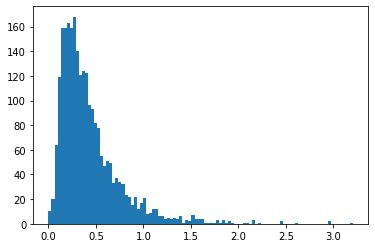

In [5]:
def create_div(res,k):
    div_dic = {}
    for key in res.keys():
        B = np.dot(res[key],res[key].T)
        x = (np.prod(sorted(np.linalg.eigvals(B))[-k:])).real #/ np.prod(sorted(1+np.linalg.eigvals(B))).real
        
        div_dic[key] = x
   
    return div_dic


topics_to_keep = 5
text_div_dic = create_div(topic_representation,topics_to_keep)
plt.hist(text_div_dic.values(),bins=100)
pickle.dump(text_div_dic,open('text_div_dic.pkl','wb'))

## 3. Create Dataframe with Diversity Information

### 3a. Load Full Data and Normalize Rating 

In [6]:
with open('../Data/all_features.pkl','rb') as f:
    all_df = pickle.load(f)

#Normalize Rating
rating_names = ['beautiful', 'confusing', 'courageous', 'fascinating', 'funny', 'informative', 'ingenious', 'inspiring', 'jaw-dropping', 'longwinded', 'obnoxious', 'ok', 'persuasive', 'unconvincing']

norm_df = pd.DataFrame({})
tot_count = all_df['total_count'].to_numpy()
for key in all_df:
    if key not in rating_names:
        norm_df[key] = all_df[key]
    else:
        rat = all_df[key].to_numpy()
        rat = rat/tot_count
        norm_df[key] = rat
all_df.head()        

,Video_ID,totalviews,total_count,beautiful,confusing,courageous,fascinating,funny,informative,ingenious,...,Female,Both,Other,White,Black_or_African_American,American_Indian_or_Alaska_Native,Asian,Native_Hawaiian_or_Other_Pacific_Islander,Latino_or_Hispanic,Other_or_mixed race
0,1,3208733,2948,58,62,140,133,545,445,57,...,1,0,0,1,0,0,0,0,0,0
1,10,2316023,1755,8,28,31,85,54,755,31,...,1,0,0,1,0,0,0,0,0,0
2,1000,614058,1413,26,29,16,393,39,260,258,...,1,0,0,1,0,0,0,0,0,0
3,1002,949193,1934,84,8,198,137,6,186,231,...,0,0,0,0,0,0,0,0,0,0
4,1003,308858,388,3,11,11,10,0,90,1,...,1,0,0,1,0,0,0,0,0,0


### 3c. Add Text Diversity

In [7]:
text_div = []
for vid in all_df['Video_ID']:
    text_div.append(text_div_dic[vid])
    
norm_df["Text Diversity"] = text_div

### 3c. Add Gesture Diversity

In [8]:
visual_variation=pickle.load(open("../Data/tid_vs_variation_visual.pkl","rb"))
vid_div = []
for vid in all_df['Video_ID']:
    if vid in visual_variation:
        vid_div.append(visual_variation[vid])
    else:
        vid_div.append(np.nan)
norm_df["Gesture Diversity"] = vid_div

### 3d. Remove Outlier w.r.t. Text Diversity and Rating

In [9]:
df = pd.DataFrame(norm_df)     
print("Shape before removing outlier: ",df.shape)

#Removing outlier w.r.t. Gesture Diversity
df = df.dropna()
q = df["Gesture Diversity"].quantile(0.99)
df = df[df["Gesture Diversity"] < q]

#Removing outlier w.r.t. Ratings
for rat in rating_names:
    q = df[rat].quantile(0.99)
    df = df[df[rat] < q]

#Removing outlier w.r.t. Text Diversity
q = df["Text Diversity"].quantile(0.99)
df = df[df["Text Diversity"] < q]
df.head()
print("Shape after removing outlier: ",df.shape)

#Scaling
things_to_scale = rating_names+["Text Diversity","Gesture Diversity"]
min_max_scaler = MinMaxScaler()
print("Text Diversity min and max before scaling",min(df["Text Diversity"]),max(df["Text Diversity"]))
df[things_to_scale] = min_max_scaler.fit_transform(df[things_to_scale])
print("Text Diversity min and max after scaling",min(df["Text Diversity"]),max(df["Text Diversity"]))

Shape before removing outlier:  (2383, 31)
Shape after removing outlier:  (1980, 31)
Text Diversity min and max before scaling 0.02142131007726288 1.3128529169046266
Text Diversity min and max after scaling 0.0 0.9999999999999999


### 3e. Binarize Ratings

In [10]:
for rat in rating_names:
    bin_rat = "bin_"+rat
    med = df[rat].median()
    df[bin_rat] = (df[rat] >= med).astype(int)  
df.head()

,Video_ID,totalviews,total_count,beautiful,confusing,courageous,fascinating,funny,informative,ingenious,...,bin_funny,bin_informative,bin_ingenious,bin_inspiring,bin_jaw-dropping,bin_longwinded,bin_obnoxious,bin_ok,bin_persuasive,bin_unconvincing
0,1,3208733,2948,0.060784,0.289738,0.144990,0.099951,0.438881,0.344936,0.063407,...,1,0,0,0,1,1,1,1,1,1
2,1000,614058,1413,0.056848,0.282747,0.034571,0.847223,0.065524,0.422387,0.598778,...,1,1,1,0,1,1,0,0,0,0
3,1002,949193,1934,0.134186,0.056987,0.312570,0.182441,0.007365,0.216595,0.391691,...,0,0,1,1,0,1,0,0,1,0
5,1004,1359837,4988,0.109011,0.035905,0.763883,0.038849,0.000476,0.414956,0.031558,...,0,1,0,0,1,0,1,0,1,0
6,1005,589982,956,0.016158,0.201749,0.383232,0.072677,0.000000,0.422609,0.106339,...,0,1,0,1,1,1,1,1,1,1


### 3f. Categorize Diversity

In [11]:
num_cat_div = 5
df["TD_cat"] = pd.cut(df["Text Diversity"],num_cat_div,labels=False)
df["GD_cat"] = pd.cut(df["Gesture Diversity"],num_cat_div,labels=False)

### 3. Create seperate dataframe for male and female

In [12]:
male_df = df[df["Female"]==1]
female_df = df[df["Female"]==0]
print("Number of male speakers: ",male_df.shape[0])
print("Number of female speakers: ",female_df.shape[0])

Number of male speakers:  1307
Number of female speakers:  673


### 3f. Create seperate dataframe for white and non-white

In [13]:
white_df = df[df["White"]==1]
nonwhite_df = df[df["White"]==0]
print("Number of white speakers: ",white_df.shape[0])
print("Number of non-white speakers: ",nonwhite_df.shape[0])

Number of white speakers:  1573
Number of non-white speakers:  407


In [14]:
crit_z = 1.96
group_df = {}
zvalue = {}
for rat in rating_names:
    cur_df = pd.DataFrame({})
    z_df = pd.DataFrame({})
    male_prob, female_prob, white_prob, nonwhite_prob, both_prob = [], [], [], [], []
    gender, race = [], []
    bin_rat = "bin_"+rat
    for cat in range(num_cat_div):
        m, f, w, nw, b = male_df['TD_cat'].value_counts()[cat], female_df['TD_cat'].value_counts()[cat], white_df['TD_cat'].value_counts()[cat], nonwhite_df['TD_cat'].value_counts()[cat], df['TD_cat'].value_counts()[cat]
        
        male_p = male_df[(male_df['TD_cat']==cat) & (male_df[bin_rat]==1)].shape[0]/float(m)
        female_p = female_df[(female_df['TD_cat']==cat) & (female_df[bin_rat]==1)].shape[0]/float(f)
        white_p = white_df[(white_df['TD_cat']==cat) & (white_df[bin_rat]==1)].shape[0]/float(w)
        nonwhite_p = nonwhite_df[(nonwhite_df['TD_cat']==cat) & (nonwhite_df[bin_rat]==1)].shape[0]/float(nw)
        both_p = df[(df['TD_cat']==cat) & (df[bin_rat]==1)].shape[0]/float(b)
      
        
        male_prob.append(male_p)
        female_prob.append(female_p)
        white_prob.append(white_p)
        nonwhite_prob.append(nonwhite_p)
        both_prob.append(both_p)
        
        z_gender = abs(male_p - female_p)/np.sqrt((male_p*(1-male_p))/float(m) + (female_p*(1-female_p))/float(f))>=crit_z
        z_race = abs(white_p - nonwhite_p)/np.sqrt((white_p*(1-white_p))/float(w) + (nonwhite_p*(1-nonwhite_p))/float(nw))>=crit_z
        
        gender.append(z_gender)
        race.append(z_race)
        
        
    
    z_df["Gender"] = gender
    z_df["Race"] = race
    
    
    cur_df["Male"] = male_prob
    cur_df["Female"] = female_prob
    cur_df["White"] = white_prob
    cur_df["Non White"] = nonwhite_prob
    cur_df["Both"] = both_prob
       
    group_df[rat] = cur_df
    zvalue[rat] = z_df

In [50]:
for vid in df[df["TD_cat"]==4]["Video_ID"].to_numpy():
    
    #print(topic_dic[vid])

SyntaxError: unexpected EOF while parsing (<ipython-input-50-4fb073bbb451>, line 2)

## 4. Plot Basic Statistics

### 4a. Plot Text Diversity distribution

Text(0, 0.5, 'Frequency')

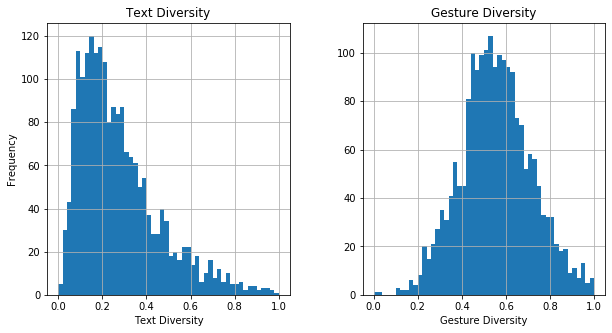

In [16]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df.hist(column = "Text Diversity", bins=50,ax=axes[0])
df.hist(column = "Gesture Diversity", bins=50,ax=axes[1])
axes[0].set_xlabel("Text Diversity")
axes[1].set_xlabel("Gesture Diversity")
axes[0].set_ylabel("Frequency")

### 4b. Plot Text Diversity distribution for different gender

/Users/rupamacharyya/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


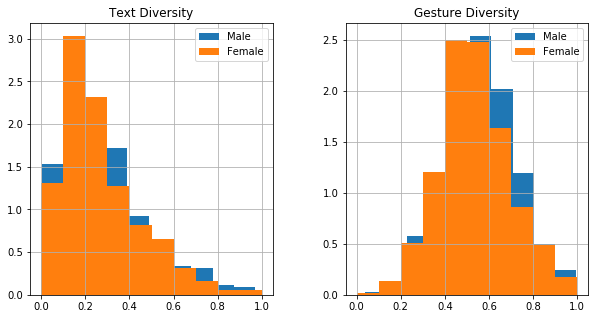

In [17]:
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol,figsize=(10,5))

male_df.hist(column = "Text Diversity",bins=10,ax=axes[0],label='Male',normed=True)
female_df.hist(column = "Text Diversity",bins=10,ax=axes[0],label='Female',normed=True)
axes[0].legend()

male_df.hist(column = "Gesture Diversity",bins=10,ax=axes[1],label='Male',normed=True)
female_df.hist(column = "Gesture Diversity",bins=10,ax=axes[1],label='Female',normed=True)
axes[1].legend()


### 4c. Plot Text Diversity distribution for different race

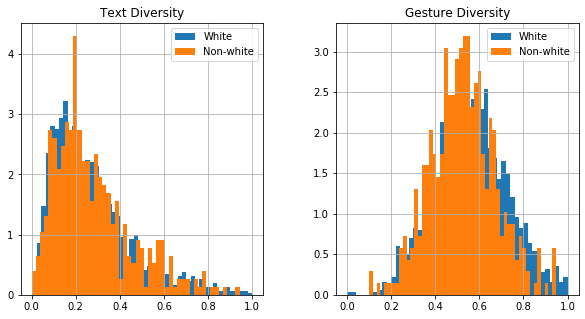

In [18]:
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol,figsize=(10,5))

white_df.hist(column = "Text Diversity",bins=50,ax=axes[0],label='White',normed=True)
nonwhite_df.hist(column = "Text Diversity",bins=50,ax=axes[0],label='Non-white',normed=True)
axes[0].legend()

white_df.hist(column = "Gesture Diversity",bins=50,ax=axes[1],label='White',normed=True)
nonwhite_df.hist(column = "Gesture Diversity",bins=50,ax=axes[1],label='Non-white',normed=True)
axes[1].legend()

### 4d. Plot Rating distribution

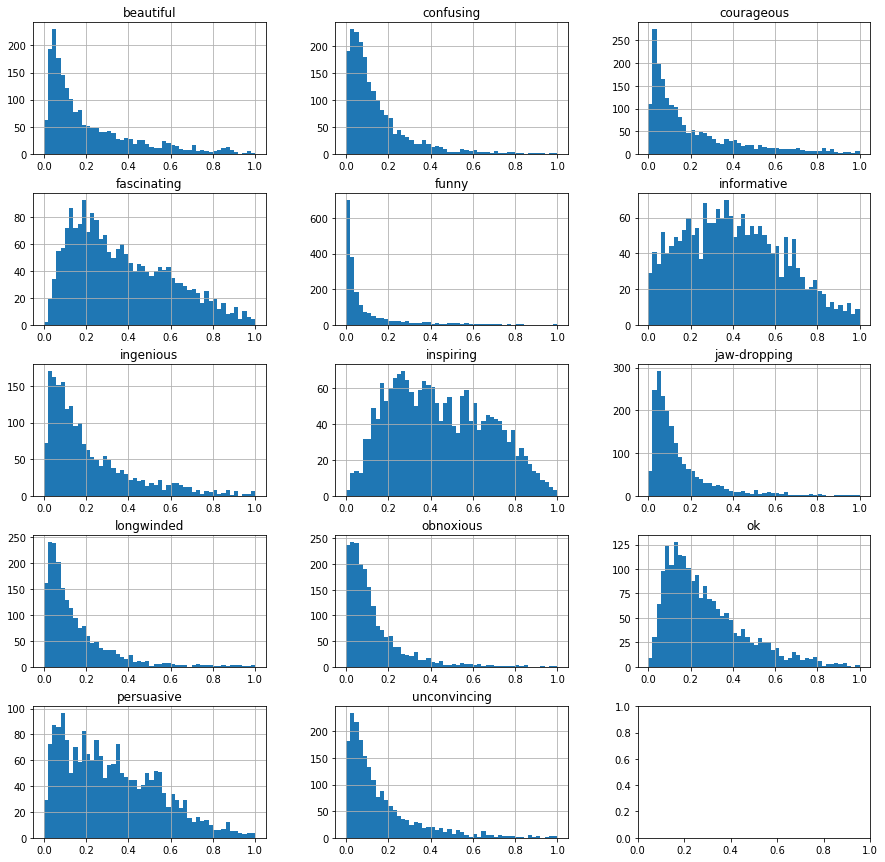

In [19]:
fig, axes = plt.subplots(5,3,figsize=(15,15))

for ind in range(14):
    df.hist(column = rating_names[ind], bins=50,ax=axes[ind//3][ind%3])

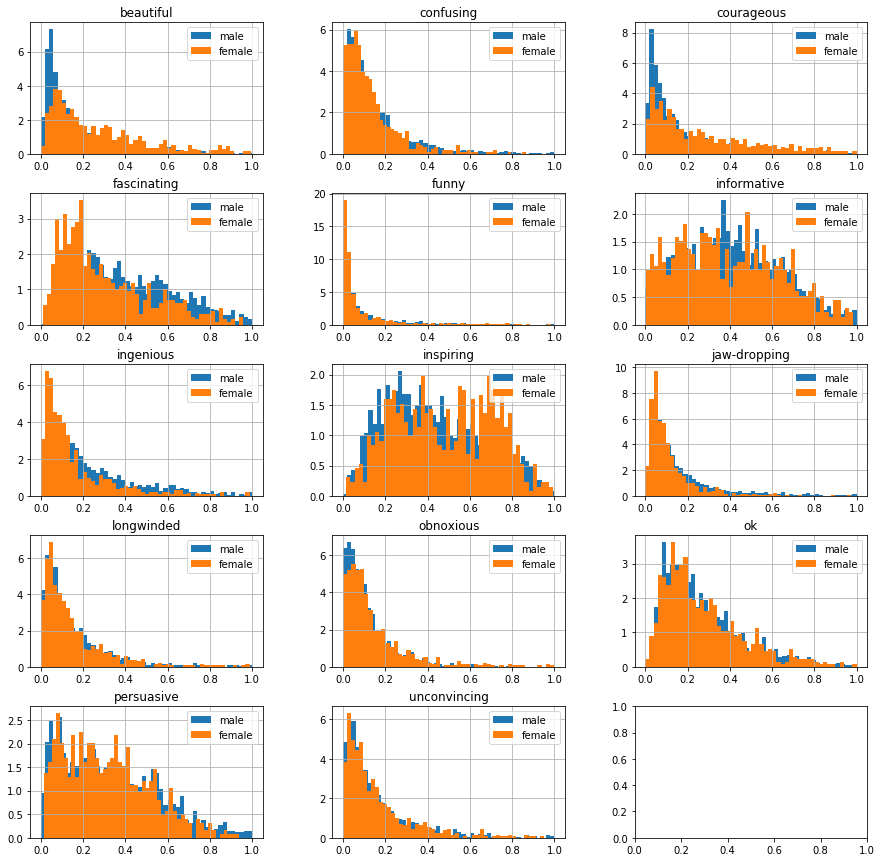

In [20]:
fig, axes = plt.subplots(5,3,figsize=(15,15))

for ind in range(14):
    male_df.hist(column = rating_names[ind], bins=50,ax=axes[ind//3][ind%3],label='male',normed=True)
    female_df.hist(column = rating_names[ind], bins=50,ax=axes[ind//3][ind%3],label='female',normed=True)
    axes[ind//3][ind%3].legend()

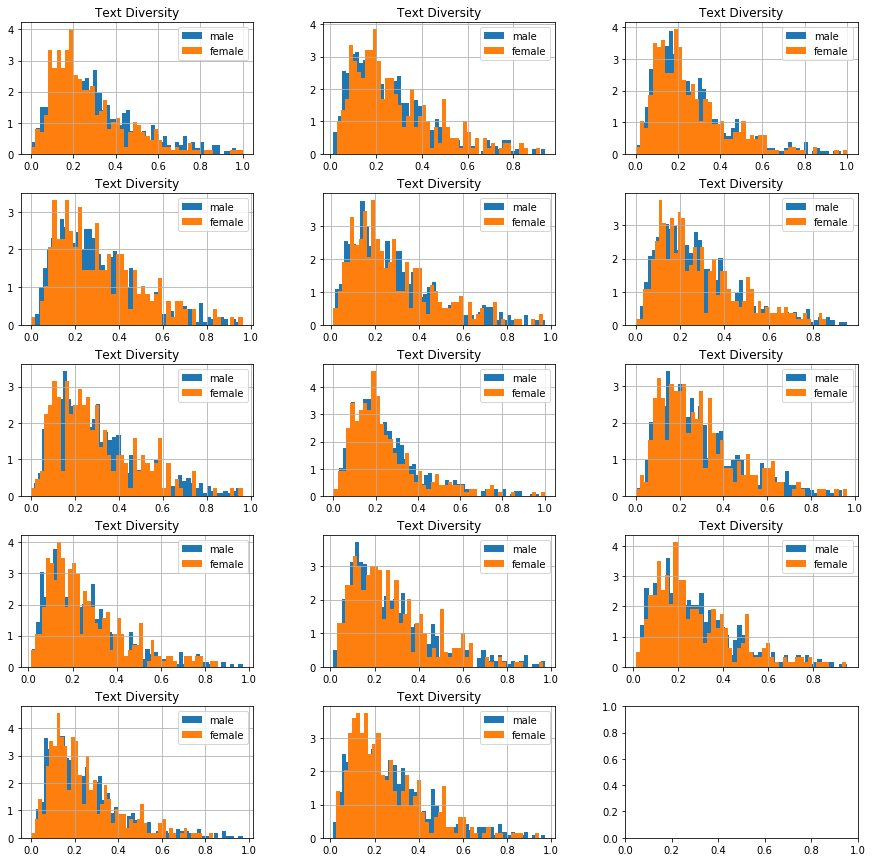

In [21]:
fig, axes = plt.subplots(5,3,figsize=(15,15))

for ind in range(14):
    col = "bin_"+ rating_names[ind]
    cur_male_df = male_df[male_df[col]==1]
    cur_female_df = female_df[female_df[col]==1]
    cur_male_df.hist(column = "Text Diversity", bins=50,ax=axes[ind//3][ind%3],label='male',normed= True)
    cur_female_df.hist(column = "Text Diversity", bins=50,ax=axes[ind//3][ind%3],label='female',normed= True)
    axes[ind//3][ind%3].legend()

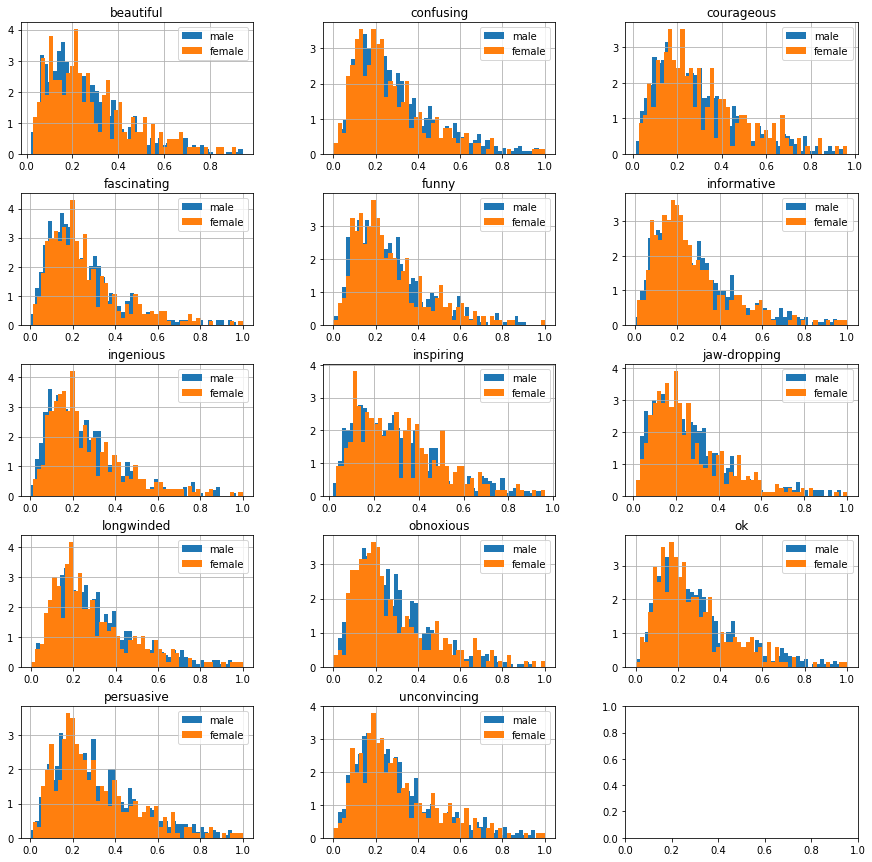

In [22]:
fig, axes = plt.subplots(5,3,figsize=(15,15))

for ind in range(14):
    col = "bin_"+ rating_names[ind]
    cur_male_df = male_df[male_df[col]==0]
    cur_female_df = female_df[female_df[col]==0]
    cur_male_df.hist(column = "Text Diversity", bins=50,ax=axes[ind//3][ind%3],label='male',normed= True)
    cur_female_df.hist(column = "Text Diversity", bins=50,ax=axes[ind//3][ind%3],label='female',normed= True)
    axes[ind//3][ind%3].set_title(rating_names[ind])
    axes[ind//3][ind%3].legend()

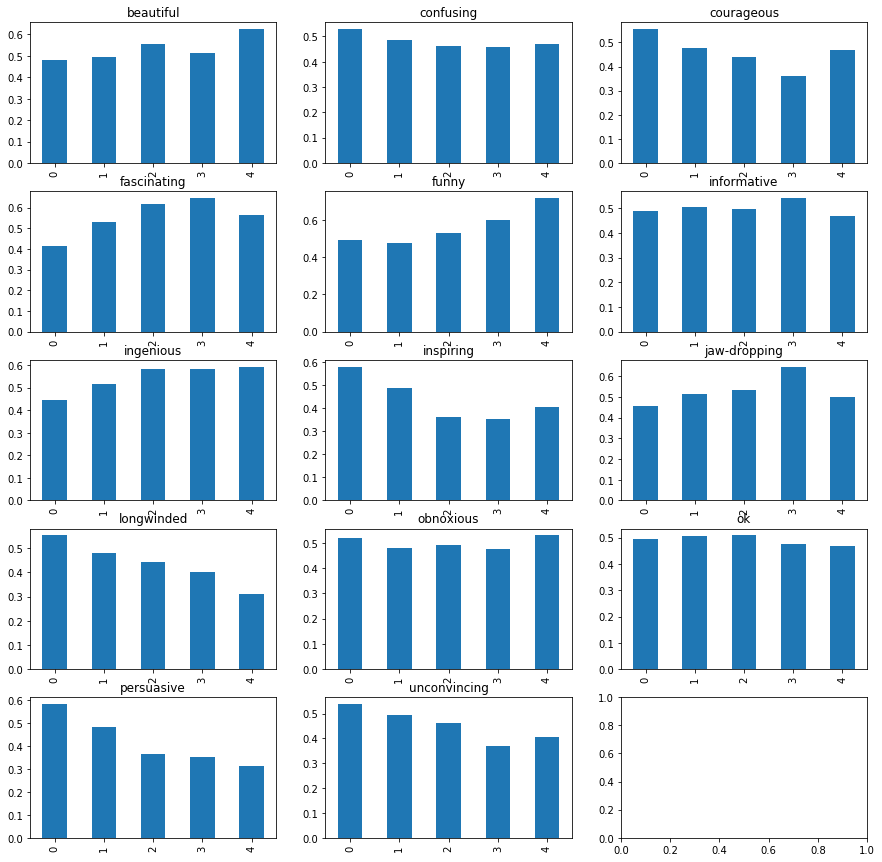

In [23]:
fig, axes = plt.subplots(5,3,figsize=(15,15))

for ind in range(14):
    cur_df = group_df[rating_names[ind]]["Both"]
    #print(cur_df)
    cur_df.plot.bar(ax=axes[ind//3][ind%3])
    axes[ind//3][ind%3].set_title(rating_names[ind])

In [47]:
# fig, axes = plt.subplots(5,3,figsize=(15,15))
# x_axis = np.linspace(0,num_cat_div,num_cat_div)

# for ind in range(14):
    
#     tf_mean = interp1d(x_axis, group_df[rating_names[ind]]["Both"].to_numpy(), kind='cubic')
   
    
#     xval = np.linspace(0,num_cat_div,100)
    
#     axes[ind//3][ind%3].plot(xval, tf_mean(xval),'-.',label='Text Mean',color='k')
#     axes[ind//3][ind%3].set_title(rating_names[ind])


### 4e. Compute Correlation

In [24]:
for rat in rating_names:
    print("Correlation between Text Diversity and ",rat," : ",df["Text Diversity"].corr(df[rat]))

Correlation between Text Diversity and  beautiful  :  0.055049583192443574
Correlation between Text Diversity and  confusing  :  -0.048985193780216055
Correlation between Text Diversity and  courageous  :  -0.08322685643010312
Correlation between Text Diversity and  fascinating  :  0.18863891341252556
Correlation between Text Diversity and  funny  :  0.102261702723222
Correlation between Text Diversity and  informative  :  0.01327140498011989
Correlation between Text Diversity and  ingenious  :  0.11393178553269581
Correlation between Text Diversity and  inspiring  :  -0.16314955146727053
Correlation between Text Diversity and  jaw-dropping  :  0.1519854056328583
Correlation between Text Diversity and  longwinded  :  -0.130629734936419
Correlation between Text Diversity and  obnoxious  :  -0.01880533944189646
Correlation between Text Diversity and  ok  :  -0.012275752761146886
Correlation between Text Diversity and  persuasive  :  -0.17756866676178698
Correlation between Text Diversity

## 5. Binning Text Diversity

### 5a. Binning Function

In [25]:
def do_binning(dl,rc,num_bin):
    #creating zipped list and removing outlier
    rat_cur = sorted(list(zip(dl,rc)))#[lower_limit:upper_limit]
       
    h,e = np.histogram(rat_cur,bins=num_bin)
    div, rating = list(zip(*rat_cur))
    n = len(div)
    min_div, max_div = min(div), max(div)
    div_ar, rating_ar = [[] for x in range(num_bin)], [[] for x in range(num_bin)]
    division = np.linspace(min_div,max_div,num_bin)
    cur_next = 1
    for i in range(n):
        if div[i] <= division[cur_next]:
            div_ar[cur_next-1].append(div[i])
            rating_ar[cur_next-1].append(rating[i])
        else:
            cur_next = cur_next+1
   
    new_div_ar, new_rating_ar = [], []
    for k in range(num_bin):
        if div_ar[k] and rating_ar[k]:
            new_div_ar.append(np.array(div_ar[k]))
            new_rating_ar.append(np.array(rating_ar[k]))
            
            
    mean_divs, mean_rates, std_divs, std_rates = [divs.mean() for divs in new_div_ar], [rates.mean() for rates in new_rating_ar], [divs.std() for divs in new_div_ar], [rates.std() for rates in new_rating_ar]
    return np.array(mean_divs), np.array(mean_rates), np.array(std_divs), np.array(std_rates)

### 5b. Errorband plot function

In [26]:
def plot_curve_multimodal_errorband(text_div_ar,text_rat_dic,visual_div_ar,visual_rat_dic,rat_name,num_bin_text,num_bin_vid,sigma=1,epsilon=0.03):
    
    text_mean_divs, text_mean_rates, text_std_divs, text_std_rates = do_binning(text_div_ar,text_rat_dic[rat_name],num_bin_text)
    visual_mean_divs, visual_mean_rates, visual_std_divs, visual_std_rates = do_binning(visual_div_ar,visual_rat_dic[rat_name],num_bin_vid)
    
    
    #interpolation
    tf_mean = interp1d(text_mean_divs, text_mean_rates,kind='cubic')
    tf_std = interp1d(text_mean_divs, text_std_rates,kind='cubic')
    
    vf_mean = interp1d(visual_mean_divs, visual_mean_rates,kind='cubic')
    vf_std = interp1d(visual_mean_divs, visual_std_rates,kind='cubic')
    
    plt.subplot(1,2,1)
    x_axis = np.linspace(min(text_mean_divs),max(text_mean_divs),100)
    #print(max(tf_mean(x_axis)))
    plt.plot(x_axis, tf_mean(x_axis),'-.',label='Text Mean',color='k')
    error = epsilon*tf_std(x_axis)
    plt.fill_between(x_axis, tf_mean(x_axis)-error,tf_mean(x_axis)+error,facecolor='#1f77b4')
    #plt.plot(all_mean_divs,polyfit(all_mean_divs,all_mean_rates,deg),'-^',label='fitted')
    plt.xlabel('Variation Metric')
    plt.ylabel('Rating')
    #plt.legend()
   
    
    plt.subplot(1,2,2)
    x_axis = np.linspace(min(visual_mean_divs),max(visual_mean_divs),100)
    plt.plot(x_axis, vf_mean(x_axis),'-.',label='Visual Mean',color='k')
    error = epsilon*vf_std(x_axis)
    plt.fill_between(x_axis, vf_mean(x_axis)-error,vf_mean(x_axis)+error,facecolor='#ff7f0e')
    #plt.plot(all_mean_divs,polyfit(all_mean_divs,all_mean_rates,deg),'-^',label='fitted')
    plt.xlabel('Variation Metric')
    #plt.ylabel('Rating')
    
    plt.subplots_adjust(wspace = 0.4)
    
    plt.suptitle(rat_name)
    #plt.legend()
    plt.savefig('Plots/Errorband/Total/'+rat_name+'_multimodal_errorband.pdf')
    plt.close()

### 5c. Errorband plot function for two groups

In [27]:
def plot_multimodal_group1_group2(text_group1_diversity_ar,text_group1_rat_dic,text_group2_diversity_ar,text_group2_rat_dic,vid_group1_diversity_ar,vid_group1_rat_dic,vid_group2_diversity_ar,vid_group2_rat_dic,rat_name,num_bin_text,num_bin_vid,group1='male',group2='other gender',sigma=3,epsilon=0.03):
    
    text_group1_mean_divs, text_group1_mean_rates,text_group1_std_divs,text_group1_std_rates = do_binning(text_group1_diversity_ar,text_group1_rat_dic[rat_name],num_bin_text)
    text_group2_mean_divs, text_group2_mean_rates, text_group2_std_divs,text_group2_std_rates = do_binning(text_group2_diversity_ar,text_group2_rat_dic[rat_name],num_bin_text)
    
    vid_group1_mean_divs, vid_group1_mean_rates,vid_group1_std_divs,vid_group1_std_rates = do_binning(vid_group1_diversity_ar,vid_group1_rat_dic[rat_name],num_bin_vid)
    vid_group2_mean_divs, vid_group2_mean_rates, vid_group2_std_divs,vid_group2_std_rates = do_binning(vid_group2_diversity_ar,vid_group2_rat_dic[rat_name],num_bin_vid)
    
    
     #interpolation
    tf1_mean = interp1d(text_group1_mean_divs, text_group1_mean_rates,kind='cubic')
    tf1_std = interp1d(text_group1_mean_divs, text_group1_std_rates,kind='cubic')
    
    vf1_mean = interp1d(vid_group1_mean_divs, vid_group1_mean_rates,kind='cubic')
    vf1_std = interp1d(vid_group1_mean_divs, vid_group1_std_rates,kind='cubic')
    
    tf2_mean = interp1d(text_group2_mean_divs, text_group2_mean_rates,kind='cubic')
    tf2_std = interp1d(text_group2_mean_divs, text_group2_std_rates,kind='cubic')
    
    vf2_mean = interp1d(vid_group2_mean_divs, vid_group2_mean_rates,kind='cubic')
    vf2_std = interp1d(vid_group2_mean_divs, vid_group2_std_rates,kind='cubic')
    
    
    plt.subplot(1,2,1)
    x_axis = np.linspace(min(text_group1_mean_divs),max(text_group1_mean_divs),100)
    plt.plot(x_axis, tf1_mean(x_axis),'-',label=group1,color='k')
    error = epsilon*tf1_std(x_axis)
    plt.fill_between(x_axis, tf1_mean(x_axis)-error,tf1_mean(x_axis)+error,facecolor='#1f77b4')
    plt.yticks(fontsize=14)
    
    x_axis = np.linspace(min(text_group2_mean_divs),max(text_group2_mean_divs),100)
    plt.plot(x_axis, tf2_mean(x_axis),'-.',label=group2,color='k')
    error = epsilon*tf2_std(x_axis)
    plt.fill_between(x_axis, tf2_mean(x_axis)-error,tf2_mean(x_axis)+error,facecolor='#8DB9D9')
    plt.yticks(fontsize=14)
    
    plt.xlabel('Variation Metric')
    plt.ylabel('Rating')
    
    plt.title('Text Data')
    plt.legend()
   
    
    plt.subplot(1,2,2)
    x_axis = np.linspace(min(vid_group1_mean_divs),max(vid_group1_mean_divs),100)
    plt.plot(x_axis, vf1_mean(x_axis),'-',label=group1,color='k')
    error = epsilon*vf1_std(x_axis)
    plt.fill_between(x_axis, vf1_mean(x_axis)-error,vf1_mean(x_axis)+error,facecolor='#ff7f0e')
    plt.yticks(fontsize=14)
    
    x_axis = np.linspace(min(vid_group2_mean_divs),max(vid_group2_mean_divs),100)
    plt.plot(x_axis, vf2_mean(x_axis),'-.',label=group2,color='k')
    error = epsilon*vf2_std(x_axis)
    plt.fill_between(x_axis, vf2_mean(x_axis)-error,vf2_mean(x_axis)+error,facecolor='#FFBD84')
    plt.yticks(fontsize=14)
    
    plt.xlabel('Variation Metric')
    #plt.ylabel('Rating')
    
    plt.title('vid Data')
    
    plt.subplots_adjust(wspace = 0.4)
    
   
    plt.title('Visual Data')
    #plt.legend()
    plt.suptitle(rat_name)
    plt.savefig('Plots/Errorband/Comparison/'+rat_name+'_multimodal_'+group1+'_'+group2+'.pdf')
    plt.close()

### 5d. Diversity array and Rating Dictionary

In [28]:
text_all_diversity_ar = df["Text Diversity"].to_numpy()
vid_all_diversity_ar = df["Gesture Diversity"].to_numpy()
text_all_rat_dic = {}
for rat in rating_names:
    text_all_rat_dic[rat] = df[rat].to_numpy()
    
text_male_diversity_ar = male_df["Text Diversity"].to_numpy()
text_female_diversity_ar = female_df["Text Diversity"].to_numpy()
vid_male_diversity_ar = male_df["Gesture Diversity"].to_numpy()
vid_female_diversity_ar = female_df["Gesture Diversity"].to_numpy()
text_male_rat_dic = {}
text_female_rat_dic = {}
for rat in rating_names:
    text_male_rat_dic[rat] = male_df[rat].to_numpy()
    text_female_rat_dic[rat] = female_df[rat].to_numpy()

### 5e. Plotting Rating w.r.t. Diversity

In [29]:
num_bin = 5
for rat_name in rating_names:
    plot_curve_multimodal_errorband(text_all_diversity_ar,text_all_rat_dic,vid_all_diversity_ar, text_all_rat_dic,rat_name,num_bin,num_bin)
for rat_name in rating_names:
    plot_multimodal_group1_group2(text_male_diversity_ar,text_male_rat_dic,text_female_diversity_ar,text_female_rat_dic,vid_male_diversity_ar,text_male_rat_dic,vid_female_diversity_ar,text_female_rat_dic,rat_name,num_bin,num_bin,group1='male',group2='other gender',sigma=3,epsilon=0.03)
